In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [ ]:
Pkg.update()
Pkg.instantiate()

In [2]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")

simulate_human_social_forces (generic function with 1 method)

### Interaction planner

In [3]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 1.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [4]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [5]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);



  0.404584 seconds (652.65 k allocations: 53.466 MiB, 6.00% gc time, 74.20% compilation time)


  0.093648 seconds (388.46 k allocations: 34.401 MiB, 21.23% gc time)


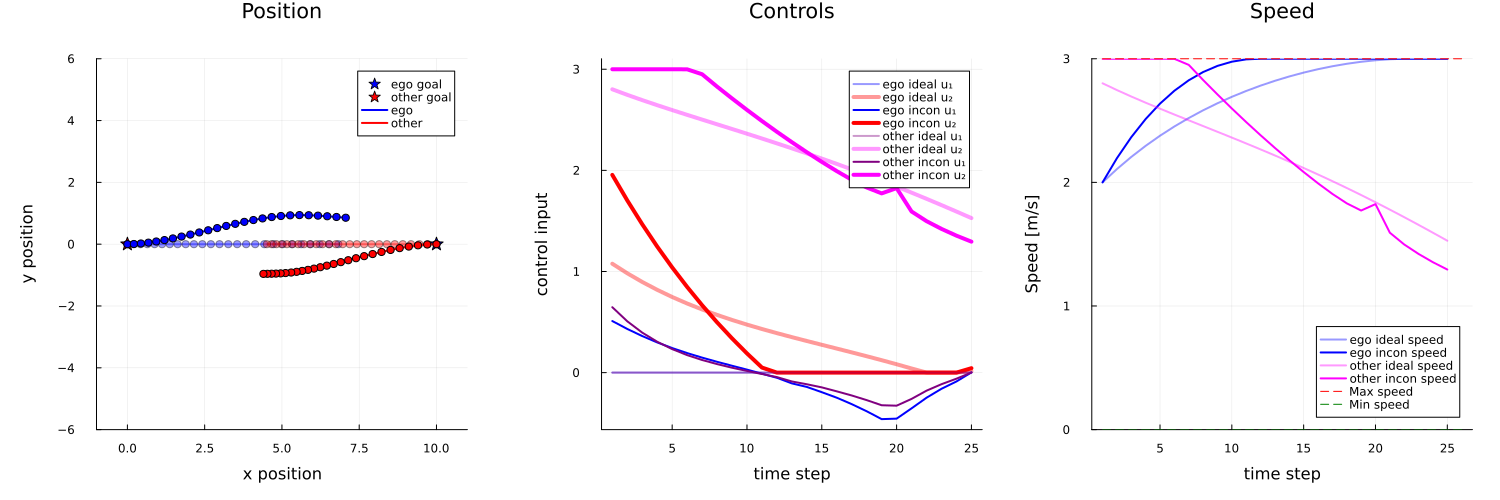

In [6]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Iterated Best Response

In [7]:
@time ibr(ip, 3, "ego")

  0.039920 seconds (250.99 k allocations: 21.714 MiB)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


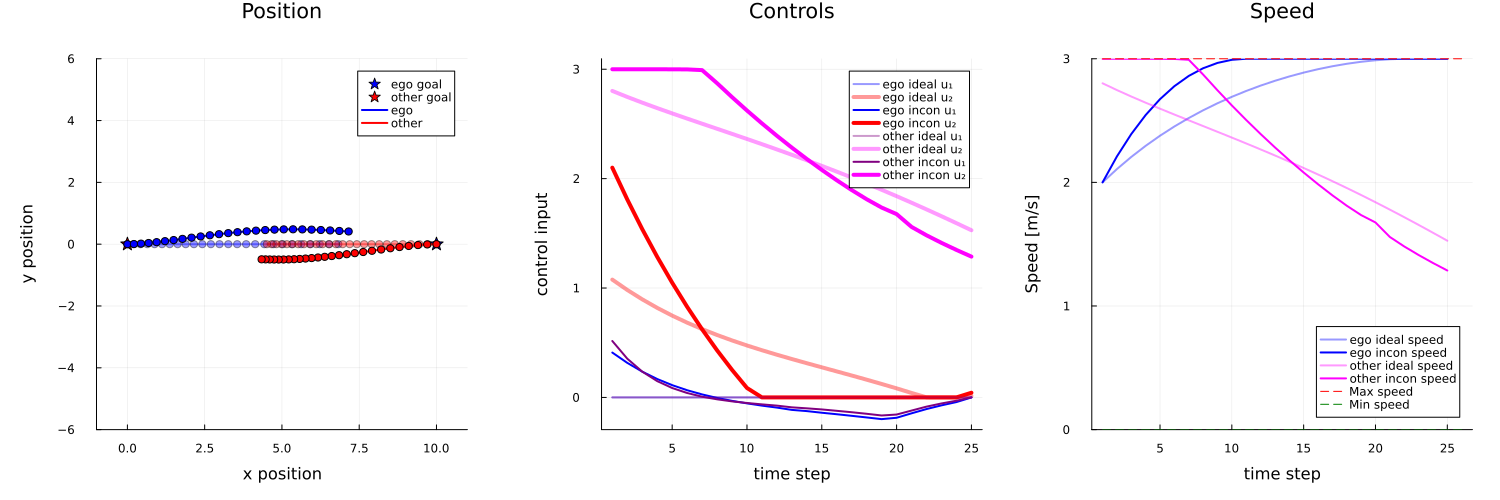

In [8]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Animation

┌ Info: Saved animation to /tmp/jl_65W1mrYZEl.gif
└ @ Plots /home/jasper/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_65W1mrYZEl.gif")
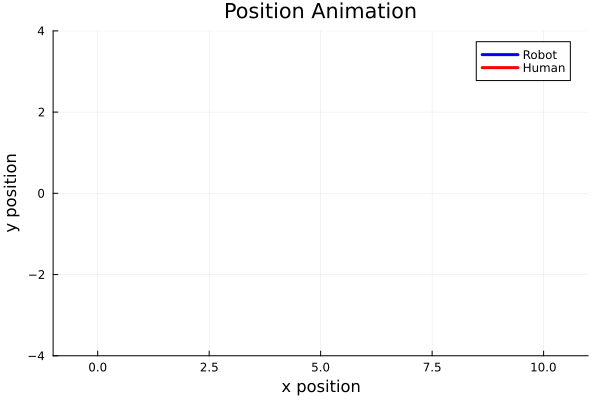

In [9]:
animation(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])

Int64

┌ Info: Saved animation to /tmp/jl_Op0dqrWDkh.gif
└ @ Plots /home/jasper/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_Op0dqrWDkh.gif")
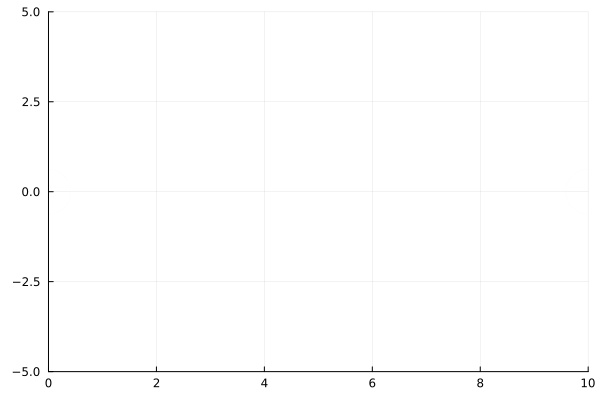

In [10]:
avoidance_animation(ip, pos_xlims=[0, 10], pos_ylims=[-5, 5])

# MPC Controller Simulation
*At the moment it is a known issue that the sim breaks if the dynamics classes used are different between the different InteractionPlanner models, will be fixed

In [11]:
include("sim.jl")
include("mpc.jl")

mpc_step (generic function with 1 method)

In [44]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [2 * pi, 2.])
# human = Unicycle(dt, velocity_max, [0.5, 3.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
#SingleIntegratorPolar2D
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
# unicycle
# Q = diagm([0.0; 0.0; 0.])
# R = diagm([1.0; .1]) 
# Qt = diagm([10.; 10.; 0.])
# dynamicalyl extended unicycle
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([100.; 100.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([100.; 100.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [45]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2]
human_goal_state = [0.; 0.; pi; 2]

solver = "ECOS"

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [46]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [3 * pi / 2, 2.])
human = Unicycle(dt, velocity_max, [0.5, 3.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
#SingleIntegratorPolar2D
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
# unicycle
# Q = diagm([0.0; 0.0; 0.])
# R = diagm([1.0; .1]) 
# Qt = diagm([10.; 10.; 0.])
# dynamicalyl extended unicycle
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([100.; 100.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([100.; 100.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [47]:
human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [48]:
robot_path, robot_controls, human_path, human_controls = simulate(robot_ip, human_ip, 50, leader="ego")

  0.118134 seconds (456.16 k allocations: 39.291 MiB, 20.09% gc time)


  0.093665 seconds (456.10 k allocations: 39.306 MiB, 11.49% gc time)


  0.086767 seconds (456.09 k allocations: 39.242 MiB, 10.51% gc time)


  0.075968 seconds (456.01 k allocations: 39.240 MiB)


  0.090878 seconds (456.09 k allocations: 39.276 MiB, 10.80% gc time)


  0.087204 seconds (456.09 k allocations: 39.242 MiB, 12.72% gc time)


  0.085914 seconds (456.10 k allocations: 39.296 MiB, 10.03% gc time)


  0.086639 seconds (456.10 k allocations: 39.246 MiB, 10.45% gc time)


  0.090562 seconds (456.09 k allocations: 39.248 MiB, 10.72% gc time)


  0.089839 seconds (456.09 k allocations: 39.284 MiB, 11.06% gc time)


  0.083684 seconds (456.10 k allocations: 39.301 MiB, 11.76% gc time)


  0.086858 seconds (456.09 k allocations: 39.267 MiB, 9.60% gc time)


  0.087864 seconds (456.09 k allocations: 39.248 MiB, 12.05% gc time)


  0.089340 seconds (456.09 k allocations: 39.247 MiB, 11.31% gc time)


  0.091151 seconds (456.09 k allocations: 39.280 MiB, 11.11% gc time)


  0.091354 seconds (456.10 k allocations: 39.297 MiB, 11.39% gc time)


  0.087366 seconds (456.10 k allocations: 39.262 MiB, 11.01% gc time)


  0.100376 seconds (456.09 k allocations: 39.244 MiB, 9.48% gc time)


  0.094962 seconds (456.09 k allocations: 39.244 MiB, 9.68% gc time)


  0.097807 seconds (456.09 k allocations: 39.276 MiB, 10.46% gc time)


  0.097894 seconds (456.10 k allocations: 39.292 MiB, 10.56% gc time)


  0.093360 seconds (456.09 k allocations: 39.256 MiB, 9.65% gc time)


  0.098391 seconds (456.09 k allocations: 39.238 MiB, 9.52% gc time)


  0.099055 seconds (456.09 k allocations: 39.237 MiB, 10.25% gc time)


  0.105591 seconds (456.09 k allocations: 39.270 MiB, 9.46% gc time)


  0.104201 seconds (456.10 k allocations: 39.284 MiB, 8.54% gc time)


  0.096737 seconds (456.09 k allocations: 39.248 MiB, 8.62% gc time)


  0.099680 seconds (456.09 k allocations: 39.229 MiB, 8.24% gc time)


  0.107521 seconds (456.09 k allocations: 39.228 MiB, 8.17% gc time)


  0.107453 seconds (456.09 k allocations: 39.260 MiB, 9.43% gc time)


  0.106000 seconds (456.11 k allocations: 39.291 MiB, 8.46% gc time)


  0.114426 seconds (456.09 k allocations: 39.221 MiB, 8.95% gc time)


  0.102018 seconds (456.01 k allocations: 39.218 MiB)


  0.113614 seconds (456.09 k allocations: 39.249 MiB, 8.42% gc time)


  0.123459 seconds (456.09 k allocations: 39.213 MiB, 7.33% gc time)


  0.106992 seconds (456.11 k allocations: 39.279 MiB, 8.40% gc time)


  0.109287 seconds (456.09 k allocations: 39.211 MiB, 8.77% gc time)


  0.092956 seconds (456.01 k allocations: 39.210 MiB)


  0.115936 seconds (456.09 k allocations: 39.245 MiB, 7.61% gc time)


  0.118170 seconds (456.09 k allocations: 39.245 MiB, 8.65% gc time)


  0.113526 seconds (456.10 k allocations: 39.245 MiB, 8.93% gc time)


  0.116700 seconds (456.09 k allocations: 39.211 MiB, 9.75% gc time)


  0.099329 seconds (456.01 k allocations: 39.210 MiB)


  0.105008 seconds (456.09 k allocations: 39.245 MiB, 10.47% gc time)


  0.104051 seconds (456.09 k allocations: 39.245 MiB, 8.47% gc time)


  0.122372 seconds (456.10 k allocations: 39.245 MiB, 7.54% gc time)


  0.113749 seconds (456.09 k allocations: 39.211 MiB, 8.55% gc time)


  0.098958 seconds (456.01 k allocations: 39.210 MiB)


  0.109850 seconds (456.09 k allocations: 39.245 MiB, 8.03% gc time)


  0.114811 seconds (456.09 k allocations: 39.245 MiB, 8.64% gc time)


([2.667683632322011e-9 0.0 0.0 2.000000007852946; 0.21499985144264994 0.0002205311032600992 0.00200482892370559 2.299999948661203; … ; 9.548350038950348 0.0567214077923928 -0.12373360165638377 0.5060047739714298; 9.596683308183131 0.05071025000342984 -0.12389084089042551 0.46810793669247375], [0.0200482892370559 2.999999408082573; 0.37537308648086415 2.999999922636329; … ; -0.0017501916875529966 -0.3945490964084741; -0.0015723923404174465 -0.37896837278956075], [10.000000000415168 6.507987840735964e-11 3.1415926535696226 2.0000000051533418; 9.785359074645282 -0.010817875239384768 3.2400178537745994 2.299999902214864; … ; 0.45208056886349923 -0.05944383737978349 3.0120794004986093 0.5064213320378981; 0.40374279635506716 -0.05314821553505849 3.0119162975054388 0.46849919918271554], [0.9842520020497668 2.9999989706152226; -0.10625702425525119 2.9999998903668286; … ; -0.0017893673096718676 -0.3945556681436248; -0.001631029931706884 -0.37922132855182517])

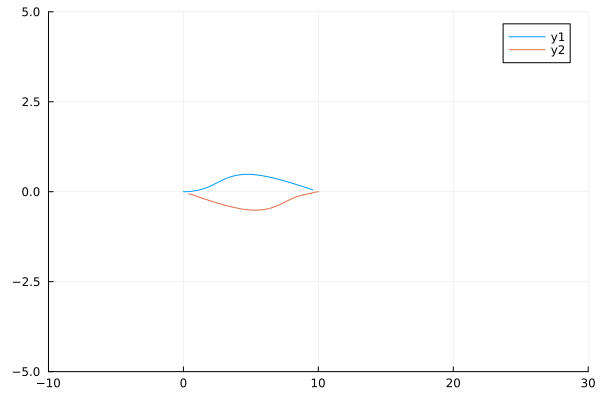

In [49]:
plt = plot(robot_path[:,1], robot_path[:,2], xlims=[-10, 30], ylims=[-5, 5])
plot!(plt, human_path[:,1], human_path[:,2])

┌ Info: Saved animation to /tmp/jl_adg7EBe72d.gif
└ @ Plots /home/jasper/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_adg7EBe72d.gif")
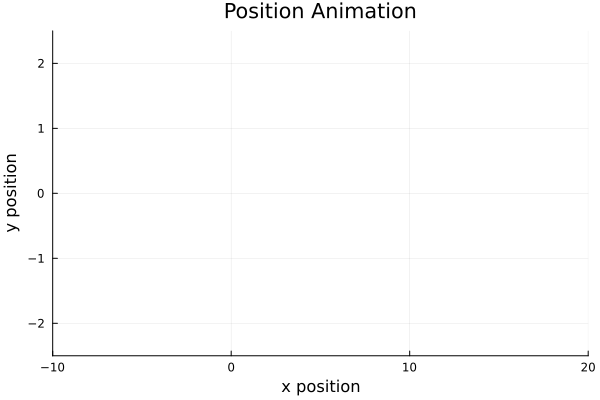

In [50]:
animation(robot_path, human_path, pos_xlims=[-10, 20], pos_ylims=[-2.5, 2.5])

# Summary Plots

### Setup the planner

In [19]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [20]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [21]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);

  0.093597 seconds (419.81 k allocations: 37.572 MiB, 19.99% gc time)


  0.085800 seconds (387.69 k allocations: 34.232 MiB, 17.66% gc time)


In [22]:
saved_data_test, _, _, _, _ = ibr_save(ip, 3, "ego")

(SaveData
  previous_ips: Array{InteractionPlanner}((3,))
, [[-5.84358850152726e-10 -6.680323935741418e-10 -3.0031737719239e-10 1.9999999996060958; 0.20681081849368305 0.004560214950930622 0.04359546956225507 2.13754512185005; … ; 6.643662213003601 0.6451048797333382 -0.08300116979752147 2.9999980713138434; 6.942880081868442 0.6202121549967533 -0.08284602611677387 3.004621359623642], [1.855425612612705e-10 -2.246189752872087e-11 -3.2478802765309317e-10 2.0000000010782126; 0.20759738428683863 0.004249186687295087 0.04041853619037213 2.1530931797335353; … ; 6.719959846678065 0.5082264832918721 -0.06794354467097567 2.999998980658651; 7.019527275807962 0.4878411622867435 -0.0679399186701304 3.004524932266363], [-8.172688413185182e-10 -6.625315986996738e-10 -3.8216831326365176e-10 2.0000000001083293; 0.20826500400425424 0.0038736607337218217 0.03669129020450409 2.1662446572652105; … ; 6.771282213492248 0.403131956189976 -0.054917902465520925 2.9999981351081826; 7.0710768021652735 0.38665113

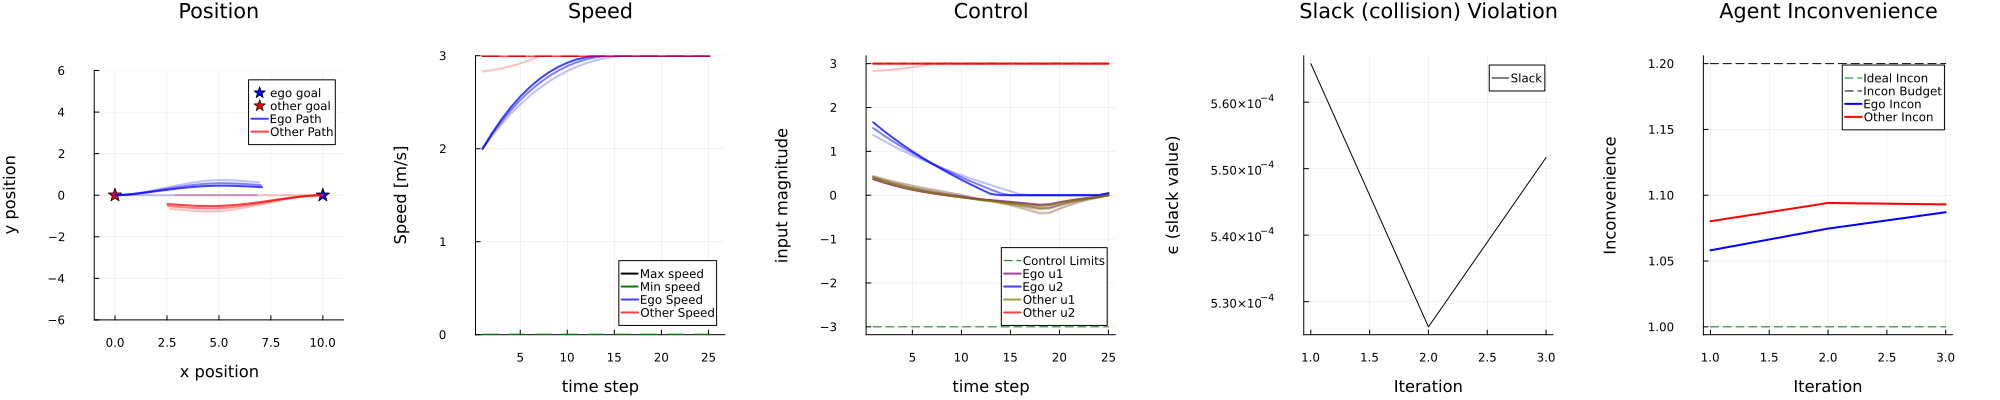

In [23]:
plot_example = plot_solve_solution(saved_data_test, scatter=false, show_speed=true, show_control=true)

In [24]:
function plot_solve_solution(problem::SaveData, second_problem::SaveData,show_theta::Bool; pos_xlims=[-1,11], pos_ylims=[-6, 6], scatter=true::Bool, show_speed=true::Bool, show_control=true::Bool)

    l = @layout [a b c d e] 
    width=2000
    height=400
    alpha_plot = 0.7
    linewidth = 2
    markersize = 2
    markersize_large = 7
    ego_color = :blue
    other_color = :red

    global iterations = length(problem.previous_ips)

    alpha_ratio = 1 / (iterations + 1)
    N = problem.previous_ips[1].ego_planner.ideal.hps.time_horizon

    ego_goal_state = problem.previous_ips[1].ego_planner.ideal.opt_params.goal_state
    other_goal_state = problem.previous_ips[1].other_planner.ideal.opt_params.goal_state

    ego_dynamics = problem.previous_ips[1].ego_planner.ideal.hps.dynamics       # use first ip arbitrarily, any iteration will give the same values for these entries
    other_dynamics = problem.previous_ips[1].other_planner.ideal.hps.dynamics

    global ego_ctrl_dim = 2
    global other_ctrl_dim = 2

    # plotting position trajectory

    plot_traj = plot(size=(height, height), xlabel="x position", ylabel="y position", title="Position", margin=10mm, ylims=pos_ylims, xlims=pos_xlims, aspect_ratio=:equal)
    scatter!(ego_goal_state[1:1], ego_goal_state[2:2], marker=:star, markersize=markersize_large, color=ego_color, label="ego goal")
    scatter!(plot_traj, other_goal_state[1:1], other_goal_state[2:2], marker=:star, markersize=markersize_large, color=other_color, label="other goal")

    plot!(plot_traj, value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

    plot!(plot_traj, value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)


    plot!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=:green, linewidth=linewidth, label="", alpha=alpha_plot)

    plot!(plot_traj, value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=:magenta, linewidth=linewidth, label="", alpha=alpha_plot)

    if scatter
        scatter!(plot_traj, value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)
    end
    # plotting speed/control

    # speed parameters
    max_speed = maximum([problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max, problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max])
    ego_max_speed = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max
    other_max_speed = problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max

    # control parameters
    ego_ctrl_dim = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.ctrl_dim
    other_ctrl_dim = problem.previous_ips[1].other_planner.ideal.hps.dynamics.ctrl_dim

    ego_max_ctrl = maximum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_max)
    ego_min_ctrl = minimum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_min)
    other_max_ctrl = maximum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_max)
    other_min_ctrl = minimum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_min)

    plot_theta = plot(size=(height, height), xlabel="time step", ylabel="abs(Theta)", title="Theta vs. time", margin=10mm, legend=:bottomright)
    plot_ctrl = plot(size=(height, height), xlabel="time step", ylabel="input magnitude", title="Control", margin=10mm)

    # angle plotting
    robot_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    robot_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    plot!(plot_theta, robot_xs_mu_09[:,3:3])
    plot!(plot_theta, human_xs_mu_09[:,3:3])
    plot!(plot_theta, robot_xs_mu_11[:,3:3])
    plot!(plot_theta, human_xs_mu_11[:,3:3])

        # ctrl plotting
    plot!(plot_ctrl, 1:N, maximum([ego_max_ctrl, other_max_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="Control Limits")
    plot!(plot_ctrl, 1:N, minimum([ego_min_ctrl, other_min_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="")   
        # ego plot
    for j in 1:ego_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 
        # other plot
    for k in 1:other_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 


    slack_violation = Vector{Float64}(undef, iterations)

    for i in 1:iterations
        slack_violation[i] = value(problem.previous_ips[i].ego_planner.incon.model[:ϵ])
    end

    plot_slack_violation = plot(size=(height, height), xlabel="Iteration", ylabel="ϵ (slack value)", title="Slack (collision) Violation", margin=10mm)

    plot!(plot_slack_violation, 1:iterations, slack_violation, color=:black, label="Slack")

    # plotting inconvenience value over iterations

    incon_budget = problem.previous_ips[1].ego_planner.incon.hps.inconvenience_ratio
    inconvenience_ego = Vector{Float64}(undef, iterations)
    inconvenience_other = Vector{Float64}(undef, iterations)

    ideal_incon_ego = compute_convenience_value(ego_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:u])), ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)

    ideal_incon_other = compute_convenience_value(other_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:u])), other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)

    for i in 1:iterations
        inconvenience_ego[i] = compute_convenience_value(ego_dynamics, problem.previous_ips[i].ego_planner.incon.opt_params.previous_states, problem.previous_ips[i].ego_planner.incon.opt_params.previous_controls, ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)
        
        inconvenience_other[i] = compute_convenience_value(other_dynamics, problem.previous_ips[i].other_planner.incon.opt_params.previous_states, problem.previous_ips[i].other_planner.incon.opt_params.previous_controls, other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)
    end

    inconvenience_ego ./= ideal_incon_ego
    inconvenience_other ./= ideal_incon_other 

    plot_incon = plot(size=(height, height), xlabel="Iteration", ylabel="Inconvenience", title="Agent Inconvenience", margin=10mm)
    plot!(plot_incon, 1:iterations, ones(iterations), linestyle=:dash, linewith=linewidth, color=:green, label="Ideal Incon")
    plot!(plot_incon, 1:iterations, ones(iterations) .+ incon_budget, linestyle=:dash, linewith=linewidth, color=:black, label="Incon Budget")
    plot!(plot_incon, 1:iterations, inconvenience_ego, color=ego_color, linewidth=linewidth, label="Ego Incon")
    plot!(plot_incon, 1:iterations, inconvenience_other, color=other_color, linewidth=linewidth, label="Other Incon")

    plot(plot_traj, plot_theta, plot_ctrl, plot_slack_violation, plot_incon, layout=l, size=(width, height))
end


plot_solve_solution (generic function with 4 methods)

# Sim Experimentation Utils

In [25]:
struct PlannerParams
    hps::PlannerHyperparameters
    opt_params::PlannerOptimizerParams
end

struct SFMParams
end

struct IPSimParams
    ego_planner_params::PlannerParams
    other_planner_params::PlannerParams
end

struct SFMSimParams
    ego_planner_params::PlannerParams
    other_planner_params::SFMParams
end

struct SimData
    sim_params
    ego_states::Matrix{Float64}
    ego_controls::Matrix{Float64}
    other_states::Matrix{Float64}
    other_controls::Matrix{Float64}
end


In [51]:
robot_params = PlannerParams(robot_ip.ego_planner.incon.hps, robot_ip.ego_planner.incon.opt_params)
human_params = PlannerParams(human_ip.ego_planner.incon.hps, human_ip.ego_planner.incon.opt_params)

PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [89.9662954667976, 90.93043770322673, 91.81720193232991, 92.63251390943817, 93.3816316350642, 94.06919965987557, 94.69931998564385, 95.27562548795373, 95.8013506870443, 96.27939794846591  …  98.49895453911945,

In [52]:
sim_params = IPSimParams(robot_params, human_params)

IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-91.96629537418505, -92.93358047687465, -93.82928039129625, -94.65834527303404, -95.42507366628527, -96.13316112833412, -96.78576635046912, -97.38557944436324, -97.93488700519752, -98.435632038513

In [53]:
sim_data = SimData(sim_params, robot_path, robot_controls, human_path, human_controls)

SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-91.96629537418505, -92.93358047687465, -93.82928039129625, -94.65834527303404, -95.42507366628527, -96.13316112833412, -96.78576635046912, -97.38557944436324, -97.93488700519752, -98.4356

In [42]:
# plotting from the SimData object
function plot_solve_solution(problem::SimData; pos_xlims=[-1,11], pos_ylims=[-6, 6])

    l = @layout [a b c] 
    width=1500
    height=500
    alpha0 = 0.2
    alpha_ideal = 0.4
    linewidth = 2
    markersize = 2
    markersize_large = 7
    ego_color = :blue
    other_color = :red

    ego_xs = problem.ego_states
    ego_us = problem.ego_controls

    other_xs = problem.other_states
    other_us = problem.other_controls

    ego_goal_state = problem.sim_params.ego_planner_params.opt_params.goal_state
    other_goal_state = problem.sim_params.other_planner_params.opt_params.goal_state

    # plotting position trajectory
    
    plot_traj = scatter(ego_goal_state[1:1], ego_goal_state[2:2], size=(width, height), xlabel="x position", ylabel="y position", title="Position", margin=10mm, marker=:star, markersize=markersize_large, color=ego_color, ylims=pos_ylims, xlims=pos_xlims, aspect_ratio=:equal, label="ego goal")
    scatter!(plot_traj, other_goal_state[1:1], other_goal_state[2:2], marker=:star, markersize=markersize_large, color=other_color, label="other goal")

    plot!(plot_traj, ego_xs[:,1], ego_xs[:,2], color=ego_color, linewidth=linewidth, label="ego")
    scatter!(plot_traj, ego_xs[:,1], ego_xs[:,2], color=ego_color, label="")

    plot!(plot_traj, other_xs[:,1], other_xs[:,2], color=other_color, linewidth=linewidth, label="other")
    scatter!(plot_traj, other_xs[:,1], other_xs[:,2], color=other_color, label="")

    # plotting speed

    ego_dynamics = problem.sim_params.ego_planner_params.hps.dynamics
    other_dynamics = problem.sim_params.other_planner_params.hps.dynamics
    N = problem.sim_params.ego_planner_params.hps.time_horizon

    ego_speed = get_speed(ego_dynamics, ego_xs, ego_us)
    other_speed = get_speed(other_dynamics, other_xs, other_us)

    plot_speed = plot(size = (width, height), xlabel="time step", ylabel="Speed [m/s]", title="Speed", margin=5mm, ylim=[0, 3], legend=:bottomright)

    plot!(plot_speed, ego_speed, color=:blue, linewidth=linewidth, label="ego incon speed")
    plot!(plot_speed, other_speed, color=:magenta, linewidth=linewidth, label="other incon speed")

    plot!(plot_speed, 1:N+1, ego_dynamics.velocity_max * ones(Float64, N+1), linestyle=:dash, linewith=linewidth, color=:red, label="Max speed")
    plot!(plot_speed, 1:N+1, ego_dynamics.velocity_min * ones(Float64, N+1), linestyle=:dash, linewith=linewidth, color=:green, label="Min speed")

    plot_ctrl = plot(size = (width, height), xlabel="time step", ylabel="control input", title="Controls", margin=10mm, alpha=alpha_ideal)

    plot!(plot_ctrl, ego_us[:,1], color=:blue, linewidth=linewidth, label="ego incon u₁")
    plot!(plot_ctrl, ego_us[:,2], color=:red, linewidth=linewidth+2, label="ego incon u₂")

    plot!(plot_ctrl, other_us[:,1], color=:purple, linewidth=linewidth, label="other incon u₁")
    plot!(plot_ctrl, other_us[:,2], color=:magenta, linewidth=linewidth+2, label="other incon u₂")

    plot(plot_traj, plot_ctrl, plot_speed, layout = l)
end

plot_solve_solution (generic function with 5 methods)

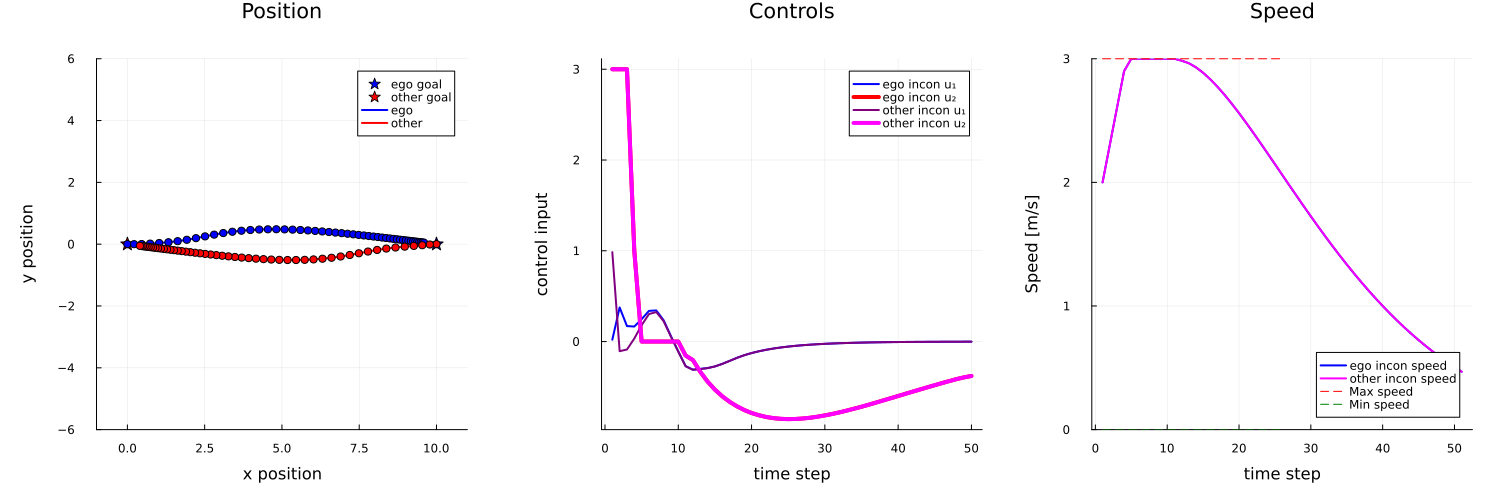

In [54]:
plot_solve_solution(sim_data)